In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Add the root directory of the package to sys.path
sys.path.append('/Users/zzhang/Workspace/SpyDust/')
sys.path.append('../')

In [2]:
MC_params = {'nh' : 3e2, 'T': 20., 'Chi': 1e-2, 'xh': 0., 'xC': 1e-4, 'y' : 0.99,  'gamma': 0, 'dipole': 9.3, 'line':7}  

In [3]:
import functools

import SpyDust.Grain as Grain
from SpyDust.SpyDust import SpyDust_given_grain_size_shape
from SpyDust.util import makelogtab

a_min=3.5e-8
a_max=3.5e-7
a2=6.0e-8
# a2=a_max

Num_a = 80
Num_beta = 80

a_tab = makelogtab(a_min, a_max, Num_a)
beta_tab  = np.linspace(-0.47, 0.5, Num_beta)


# beta_tab_disk = np.linspace(-0.48, -0.2, Num_beta)
# beta_tab_ellip = np.linspace(-0.2, 0.2, Num_beta)

def cache_last_call(func):
    last_args = {"args": None, "kwargs": None, "result": None}

    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        # Compare with last args
        if (last_args["args"] is not None 
            and len(args) == len(last_args["args"]) 
            and all(np.array_equal(a, b) if isinstance(a, np.ndarray) else a == b
                    for a, b in zip(args, last_args["args"])) 
            and kwargs == last_args["kwargs"]):
            return last_args["result"]

        # Otherwise, compute new
        result = func(*args, **kwargs)
        last_args["args"] = args
        last_args["kwargs"] = kwargs
        last_args["result"] = result
        return result

    return wrapper

@cache_last_call
def generate_same_grains_SED(env, a, beta, a2):
    # if "a" is a number, return a single SED result; if "a" is a table, return a table of SED results
    if isinstance(a, (int, float)):
        result = SpyDust_given_grain_size_shape(env, a, beta, 
                                                min_freq=0.1, max_freq=100.0, n_freq=200,
                                                N_angular_Omega=500,
                                                a2=a2
                                                )
        result_SED = result[1]
    else:
        result_SED = []
        for a_val in a:
            result = SpyDust_given_grain_size_shape(env, a_val, beta, 
                                                min_freq=0.1, max_freq=100.0, n_freq=200,
                                                N_angular_Omega=500,
                                                a2=a2)
            result_SED.append(result[1])
        result_SED = np.array(result_SED)

    freqs = result[0]
    return freqs, result_SED

def SED_list_given_SSE(a_beta_tab, env, a2):   
    # generate the SED list given the tables of grain size (S) a_tab, grain shape (S) beta_tab, and the environment (E)
    SED_list = []
    from tqdm import tqdm
    for a, beta in tqdm(a_beta_tab):
        freqs, result = generate_same_grains_SED(env, a, beta, a2=a2)
        SED_list.append(result)
    return freqs,np.array(SED_list)

l_a computed
readPAH computed
Loaded previously computed Jpeisrf arrays from file.
Tev table already exists at /Users/zzhang/Workspace/SpyDust/SpyDust/Data_Files/Tev_30a_30chi.txt.
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
Gaunt factor stored


/Users/zzhang/Workspace/SpyDust/SpyDust/free_free.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(gff_data_file, delim_whitespace=True, comment=';', header=None, names=['gamma2', 'u', 'gff'])
/Users/zzhang/Workspace/SpyDust/SpyDust/SED_fit.py:408: SyntaxWarning: invalid escape sequence '\l'
  :math:`x_i = \ln \nu_i` and local spacings :math:`\Delta x_i`, we define


In [4]:
env = MC_params
a_beta_tab = np.array(np.meshgrid(a_tab, beta_tab)).T.reshape(-1, 2)

freqs, MC_SEDs_a_beta =  SED_list_given_SSE(a_beta_tab, env, a2=a2) # tumbling grains


100%|██████████| 6400/6400 [13:15<00:00,  8.04it/s]


In [5]:
from SpyDust.SED_fit import fit_sed_ensemble

In [6]:
MC_features_a_beta =  fit_sed_ensemble(freqs, MC_SEDs_a_beta, thres=1e-3)

100%|██████████| 6400/6400 [00:00<00:00, 7553.39it/s]


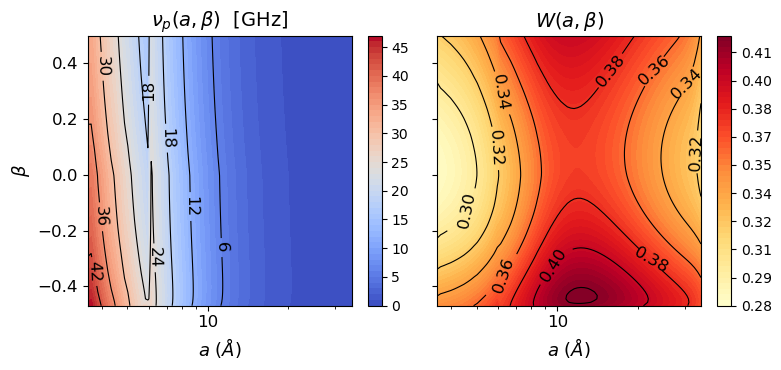

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, NullFormatter


features = MC_features_a_beta


X = a_beta_tab.reshape(Num_a,Num_beta,2)[:, :, 0]*1e8
Y = a_beta_tab.reshape(Num_a,Num_beta,2)[:, :, 1]
Z1 = np.exp(features.reshape(Num_a,Num_beta,2)[:, :, 0])
Z2 = features.reshape(Num_a,Num_beta,2)[:, :, 1]

# -------------------------
# Create the plot
# -------------------------
fig, ax = plt.subplots(1, 2, figsize=(8, 3.8), sharey=True)
ax = ax.flatten()

# Filled heatmap (smooth color shading)
# cmap = plt.cm.viridis
cmap = plt.cm.coolwarm
heat = ax[0].contourf(X, Y, Z1, levels=50, cmap=cmap)

# Contour lines (iso-values)
contours = ax[0].contour(X, Y, Z1, levels=8, colors='black', linewidths=0.8)
ax[0].clabel(contours, inline=True, fontsize=12, fmt="%.0f")

# Colorbar
cbar = fig.colorbar(heat, ax=ax[0])
# cbar.set_label("Function value", fontsize=12)
ax[0].set_xscale('log')

# Axis labels and style
ax[0].set_xlabel(r"$a$ ($\AA$)", fontsize=13)
ax[0].set_ylabel(r"$\beta$", fontsize=13)
ax[0].set_title(fr"$\nu_p(a, \beta)$  [GHz]", fontsize=14)
ax[0].tick_params(labelsize=12)

cmap = plt.cm.YlOrRd
heat = ax[1].contourf(X, Y, Z2, levels=50, cmap=cmap)
contours = ax[1].contour(X, Y, Z2, levels=8, colors='black', linewidths=0.8)
# ax[1].clabel(contours, inline=True, fontsize=10, fmt="%.2f",
#             rightside_up=True, inline_spacing=15)

ax[1].margins(0.05)  # Small margin
levels_to_label = contours.levels[1:-1] if len(contours.levels) > 2 else contours.levels
ax[1].clabel(contours, levels=levels_to_label, inline=True, fontsize=12, fmt="%.2f",
             rightside_up=True)

ax[1].set_xscale('log')

cbar = fig.colorbar(heat, ax=ax[1], format="%.2f")
ax[1].set_xlabel(r"$a$ ($\AA$)", fontsize=13)
# ax[1].set_ylabel(r"$\beta$", fontsize=13)
ax[1].set_title(fr"$W(a, \beta)$", fontsize=14)
ax[1].tick_params(labelsize=12)

formatter = FuncFormatter(lambda value, _: f"{value:g}")
for axis in ax:
    axis.xaxis.set_major_formatter(formatter)
    axis.xaxis.set_minor_formatter(NullFormatter())

fig.tight_layout()

plt.savefig("figures/MC_feature_map_varying_size_shape.pdf", dpi=300)
plt.show()

[ 3.65441651e-08 -2.24430380e-01]


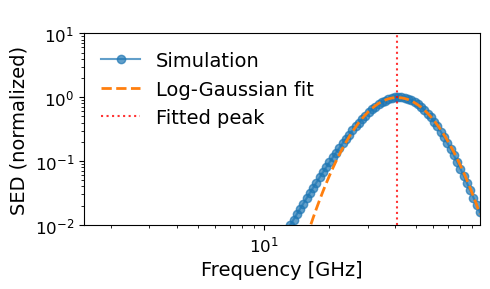

{'f_peak': np.float64(40.839327875551504),
 'sigma': np.float64(0.3013213720622382),
 'fwhm': np.float64(29.589590438122926),
 'r_squared': np.float64(0.9966409399646898),
 'amplitude': np.float64(1.732855795360411e-10),
 'f_peak_error': np.float64(151732.06173890777),
 'sigma_error': np.float64(0.0022727664956876483),
 'n_points_used': 58,
 'threshold_value': np.float64(2.1043813474011984e-12)}

In [8]:
import importlib
import SpyDust.SED_fit
importlib.reload(SpyDust.SED_fit)
from SpyDust.SED_fit import measure_sed_peak_properties

ind=100
print(a_beta_tab[ind])
measure_sed_peak_properties(freqs, MC_SEDs_a_beta[ind], plot=True, save_path="figures/SED_fit_example.pdf", thres=1e-2, title=' ')


## Distribution of grain size

In [70]:
import SpyDust.Grain as Grain


def eval_beta_arbitrary(a, d):
    if a <= a2:
        beta_val = Grain.cylindrical_params(a, d)[1]
    else:
        beta_val=0.
    return beta_val

def _normalise(w):
    """Turn any non-negative weight array into a PDF."""
    w = np.asarray(w, dtype=float)
    if np.any(w < 0):                       # sanity check
        raise ValueError("Weights must be non-negative.")
    s = w.sum()
    if s == 0:
        raise ValueError("All weights are zero → cannot normalise.")
    return w / s

# a_list = np.concatenate((a_tab_disk, a_tab_ellip))
a_list = a_tab

def grain_size_dist(gamma, log_a0, sigma):
    """
    dn/da propto exp[(gamma - 1) lna - 1/2 ((ln(a) - ln(a0) + sigma**2/2)^2 / sigma^2)]
    equivalent to
    dn/dlna propto exp[gamma * lna - 1/2 ((ln(a) - ln(a0) + sigma**2/2)^2 / sigma^2)]
    """
    ln_a_list = np.log(a_list)
    exponent = gamma  * ln_a_list - 0.5 * ( (ln_a_list - log_a0 + sigma**2/2) / sigma ) ** 2
    max_exponent = np.max(exponent)
    exponent -= max_exponent
    weights = np.exp(exponent)
    dln_a_1 =  ln_a_list[1] - ln_a_list[0]
    dln_a_2 =  ln_a_list[-1] - ln_a_list[-2]
    assert np.isclose(dln_a_1, dln_a_2), "a_list not evenly spaced in log-space"
    return _normalise(weights)

def grain_shape_dist(a, d, delta):
    beta_tab = beta_tab_disk
    ln_beta_t_tab = np.log( beta_tab + 0.5 )
    ln_beta_d_t = np.log( eval_beta_arbitrary(a, d) + 0.5 )
    exponent = - ln_beta_t_tab - 0.5 * ( (ln_beta_t_tab  - ln_beta_d_t + delta**2/2 ) / delta ) ** 2
    max_exponent = np.max(exponent)
    exponent -= max_exponent
    weights = np.exp(exponent)
    return _normalise(weights)

aux = np.where(a_tab <= a2)
Num_a_disk = aux[0].size
a_tab_disk = a_tab[:Num_a_disk]
a_tab_ellip = a_tab[Num_a_disk:]

def generate_size_shape_dist(gamma, log_a0, sigma, d, delta):
    distr_a_beta_disk = np.zeros((Num_a_disk, Num_beta))

    distr_a = grain_size_dist(gamma, log_a0, sigma)
    distr_a_disk = distr_a[:Num_a_disk]
    distr_a_ellip = distr_a[Num_a_disk:]

    for i in range(Num_a_disk):
        a = a_tab[i]
        distr_a_beta_disk[i, :] = grain_shape_dist(a, d, delta) * distr_a_disk[i]

    return distr_a_beta_disk, distr_a_ellip
    

In [17]:
# Generate SEDs for larger, spherical grains (beta=0)

a_beta_tab_sphe = []
for a in a_tab_ellip:
    a_beta_tab_sphe.append([a, 0.])
a_beta_tab_sphe = np.array(a_beta_tab_sphe)

freqs, MC_SEDs_sphe =  SED_list_given_SSE(a_beta_tab_sphe, MC_params, a2=a2)

# Generate SEDs for smaller, disk-like grains
a_beta_tab_small = np.array(np.meshgrid(a_tab_disk, beta_tab)).T.reshape(-1, 2)
freqs, MC_SEDs_small =  SED_list_given_SSE(a_beta_tab_small, MC_params, a2=a2)


100%|██████████| 1520/1520 [03:59<00:00,  6.35it/s]


In [71]:
def synthesize_SED(gamma, log_a0, sigma, d, delta):
    distr_a_beta_disk, distr_a_ellip = generate_size_shape_dist(gamma, log_a0, sigma, d, delta)
    SED_disk = np.sum(distr_a_beta_disk[:, :, np.newaxis] * MC_SEDs_small.reshape(Num_a_disk,Num_beta,-1), 
                        axis=(0, 1))
    SED_ellip = np.sum(distr_a_ellip[:, np.newaxis] * MC_SEDs_sphe, axis=0)
    return SED_disk + SED_ellip

In [51]:
# reference values of the parameters:
gamma_ref, log_a0_ref, sigma_ref, d_ref, delta_ref = 0., np.log(a2), 0.5, Grain.d, 0.01


In [ ]:
# from SpyDust.SED_fit import measure_sed_peak_properties
# Reload the module and SED fitting function
import importlib
import SpyDust
importlib.reload(SpyDust.SED_fit)



In [54]:
gamma_list = np.linspace(-2.5, 2, 100)
log_a0_list = np.linspace(np.log(a_min), np.log(a_max), 100)
sigma_list = makelogtab(0.01, 10, 100)
d_list = np.linspace(Grain.d/2, Grain.d*2, 100)
delta_list = makelogtab(0.001, 1, 100)

In [72]:

SED_gamma_list = []
for gamma in gamma_list:
    SED_gamma_list.append(synthesize_SED(gamma, log_a0_ref, sigma_ref, d_ref, delta_ref))
SED_gamma_list = np.array(SED_gamma_list)

SED_log_a0_list = []
for log_a0 in log_a0_list:
    SED_log_a0_list.append(synthesize_SED(gamma_ref, log_a0, sigma_ref, d_ref, delta_ref))
SED_log_a0_list = np.array(SED_log_a0_list)

SED_sigma_list = []
for sigma in sigma_list:
    SED_sigma_list.append(synthesize_SED(gamma_ref, log_a0_ref, sigma, d_ref, delta_ref))
SED_sigma_list = np.array(SED_sigma_list)

SED_d_list = []
for d in d_list:
    SED_d_list.append(synthesize_SED(gamma_ref, log_a0_ref, sigma_ref, d, delta_ref))
SED_d_list = np.array(SED_d_list)

SED_delta_list = []
for delta in delta_list:
    SED_delta_list.append(synthesize_SED(gamma_ref, log_a0_ref, sigma_ref, d_ref, delta))
SED_delta_list = np.array(SED_delta_list)


In [ ]:
SED_gamma_features = fit_sed_ensemble(freqs, SED_gamma_list, thres=1e-3)

SED_log_a0_features = fit_sed_ensemble(freqs, SED_log_a0_list, thres=1e-3)

SED_sigma_features = fit_sed_ensemble(freqs, SED_sigma_list, thres=1e-3)

SED_d_features = fit_sed_ensemble(freqs, SED_d_list, thres=1e-3)

SED_delta_features = fit_sed_ensemble(freqs, SED_delta_list, thres=1e-3)

100%|██████████| 100/100 [00:00<00:00, 5679.49it/s]


In [ ]:
SED_ref = synthesize_SED(gamma_ref, log_a0_ref, sigma_ref, d_ref, delta_ref)

SED_ref_features = fit_sed_ensemble(freqs, SED_ref, thres=1e-3)

100%|██████████| 1/1 [00:00<00:00, 1649.35it/s]


In [62]:
SED_ref_features

array([3.42526718, 0.48445645])

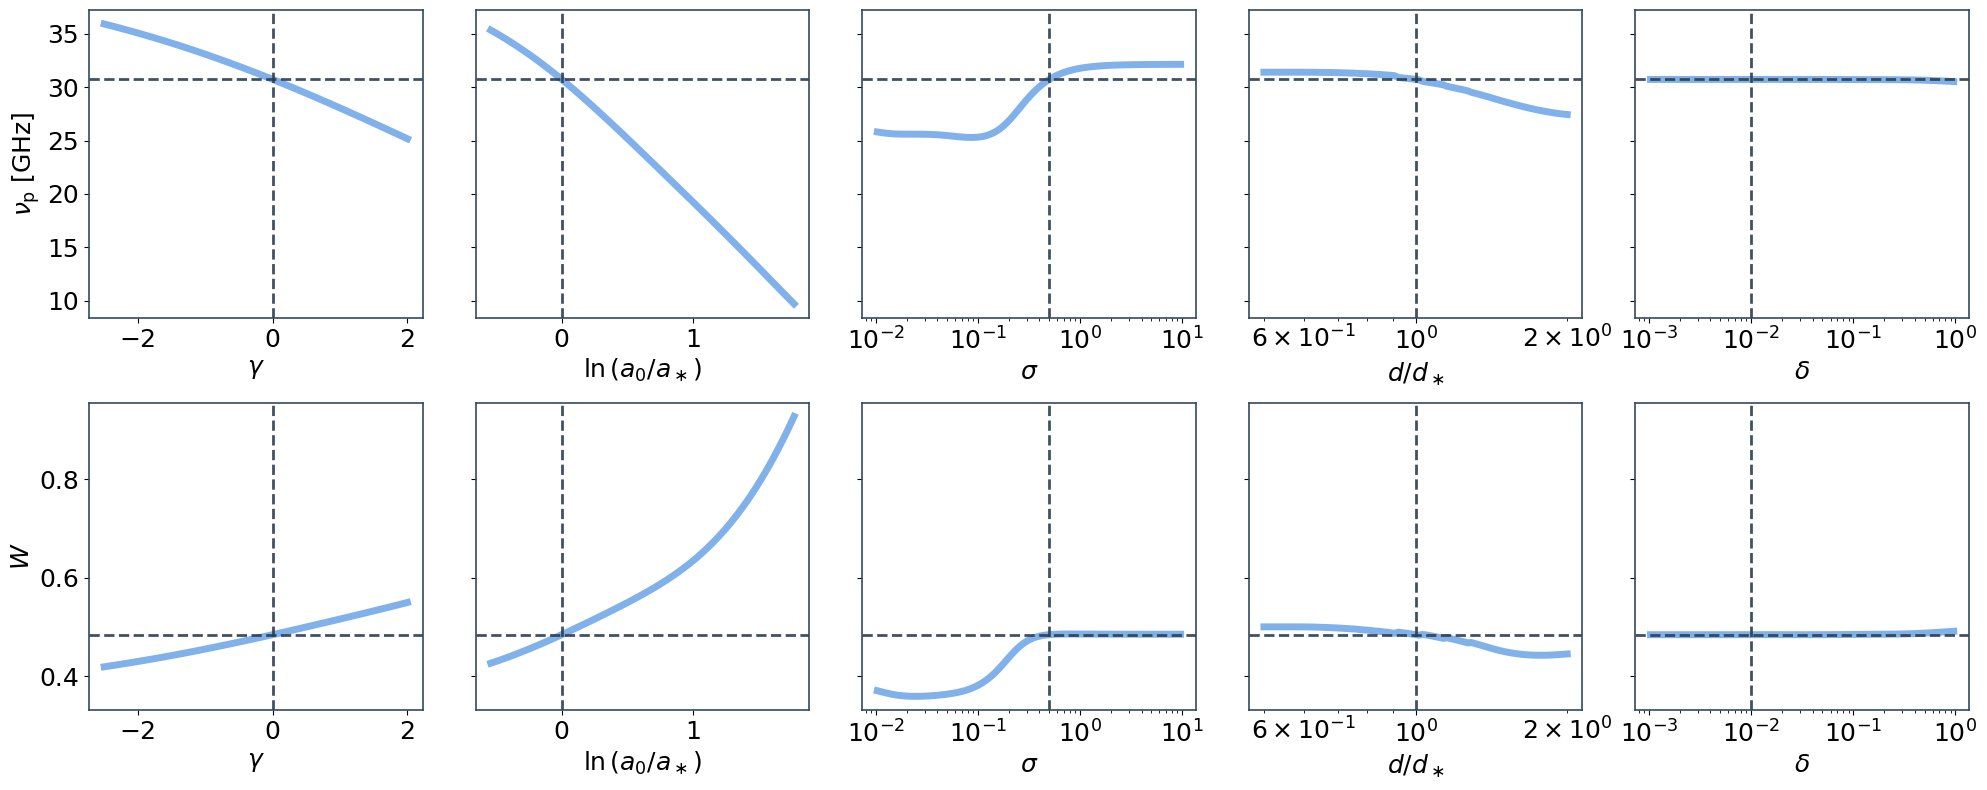

In [ ]:
import matplotlib.pyplot as plt

# Create figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey='row')

# Define improved styling
curve_color = '#4A90E2'  # Light blue
curve_alpha = 0.7
curve_linewidth = 5
ref_color = '#2C3E50'  # Dark blue-gray
ref_linewidth = 2
ref_alpha = 0.9

# First row - nu_p [GHz] (exponential of first feature)
axes[0, 0].plot(gamma_list, np.exp(SED_gamma_features[:, 0]), 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[0, 0].set_xlabel(r'$\gamma$')
# show the reference value
axes[0, 0].axvline(gamma_ref, color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[0, 0].axhline(np.exp(SED_ref_features[0]), color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

axes[0, 1].plot(log_a0_list - np.log(a2), np.exp(SED_log_a0_features[:, 0]), 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[0, 1].set_xlabel(r'$\ln{{(a_0 / a_\ast)}}$')
# show the reference value
axes[0, 1].axvline(log_a0_ref - np.log(a2), color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[0, 1].axhline(np.exp(SED_ref_features[0]), color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

axes[0, 2].plot(sigma_list, np.exp(SED_sigma_features[:, 0]), 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[0, 2].set_xscale('log')
axes[0, 2].set_xlabel(r'$\sigma$')
# show the reference value
axes[0, 2].axvline(sigma_ref, color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[0, 2].axhline(np.exp(SED_ref_features[0]), color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

axes[0, 3].plot(d_list/d_ref, np.exp(SED_d_features[:, 0]), 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[0, 3].set_xlabel(r'$d/d_\ast$')
axes[0, 3].set_xscale('log')
# show the reference value
axes[0, 3].axvline(1., color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[0, 3].axhline(np.exp(SED_ref_features[0]), color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

axes[0, 4].plot(delta_list, np.exp(SED_delta_features[:, 0]), 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[0, 4].set_xscale('log')
axes[0, 4].set_xlabel(r'$\delta$')
# show the reference value
axes[0, 4].axvline(delta_ref, color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[0, 4].axhline(np.exp(SED_ref_features[0]), color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

# Set shared y-label for first row
axes[0, 0].set_ylabel(r'$\nu_{\rm p}$ [GHz]')

# Second row - beta (second feature)
axes[1, 0].plot(gamma_list, SED_gamma_features[:, 1], 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[1, 0].set_xlabel(r'$\gamma$')
axes[1, 0].axvline(gamma_ref, color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[1, 0].axhline(SED_ref_features[1], color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

axes[1, 1].plot(log_a0_list - np.log(a2), SED_log_a0_features[:, 1], 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[1, 1].set_xlabel(r'$\ln{{(a_0 / a_\ast)}}$')
# show the reference value
axes[1, 1].axvline(log_a0_ref - np.log(a2), color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[1, 1].axhline(SED_ref_features[1], color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

axes[1, 2].plot(sigma_list, SED_sigma_features[:, 1], 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[1, 2].set_xscale('log')
axes[1, 2].set_xlabel(r'$\sigma$')
# show the reference value
axes[1, 2].axvline(sigma_ref, color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[1, 2].axhline(SED_ref_features[1], color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

axes[1, 3].plot(d_list / d_ref, SED_d_features[:, 1], 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[1, 3].set_xlabel(r'$d/d_\ast$')
axes[1, 3].set_xscale('log')
# show the reference value
axes[1, 3].axvline(1., color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[1, 3].axhline(SED_ref_features[1], color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

axes[1, 4].plot(delta_list, SED_delta_features[:, 1], 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[1, 4].set_xscale('log')
axes[1, 4].set_xlabel(r'$\delta$')
# show the reference value
axes[1, 4].axvline(delta_ref, color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[1, 4].axhline(SED_ref_features[1], color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

# Set shared y-label for second row
axes[1, 0].set_ylabel(r'$W$')

# Enhanced styling
font_size = 18
for ax in axes.flat:
    ax.tick_params(axis='both', which='both', labelsize=font_size)
    ax.set_title(ax.get_title(), fontsize=font_size)
    ax.set_xlabel(ax.get_xlabel(), fontsize=font_size)
    ax.set_ylabel(ax.get_ylabel(), fontsize=font_size)
    # Add subtle grid for better readability
    # ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    # Improve spine appearance
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
        spine.set_color('#34495E')

# Adjust layout and show
plt.tight_layout()
plt.savefig("figures/SED_feature_given_distribution.pdf", dpi=300, bbox_inches='tight')
plt.show()